In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn
import os

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

## load dataset 

In [2]:
# Loading in Kaggle's sample submission file for uploading
submission = pd.read_csv('/kaggle/input/playground-series-s4e9/sample_submission.csv')
# Applying predicted 'price' values to 'submission'
# submission['price'] = y_pred
# Exporting 'submission' as a .csv for scoring
# submission.to_csv('submission.csv', index=False)

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB
None


,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


Total null values in the dataset 28954
columns Index(['fuel_type', 'accident', 'clean_title'], dtype='object')
 -- Null value for column fuel_type: 5083
 -- Null value for column accident: 2452
 -- Null value for column clean_title: 21419



All the unique values in the dataset
 -- brand has: 57, too many to list



 -- model has: 1897, too many to list





/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


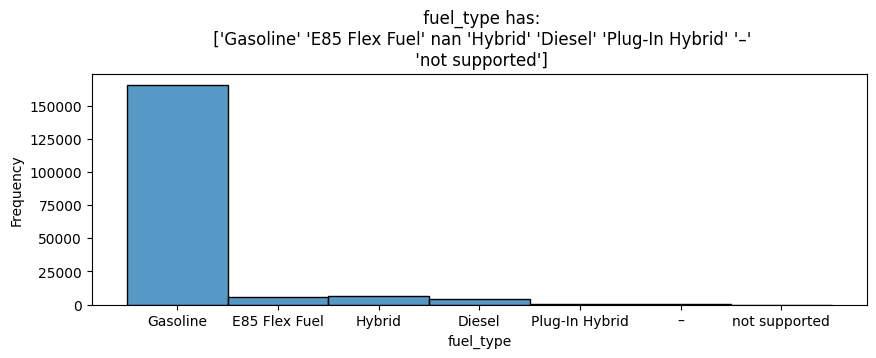




 -- engine has: 1117, too many to list



 -- transmission has: 52, too many to list



 -- ext_col has: 319, too many to list



 -- int_col has: 156, too many to list





/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


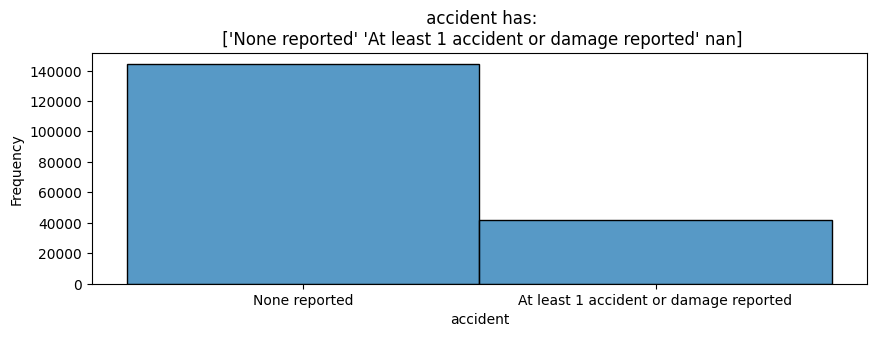

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


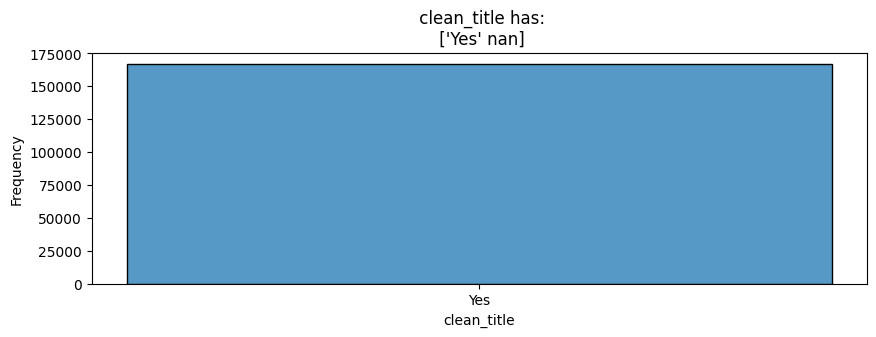

In [4]:
def nullValuesCols(df):
    columns_with_null = df.columns[df.isnull().any()]
    print(f'Total null values in the dataset {df.isnull().sum().sum()}')
    print(f'columns {columns_with_null}')
    for col in columns_with_null:
        print(f' -- Null value for column {col}: {df[col].isnull().sum()}')
    print('\n\n')
    
    
def uniqueVlaues(df):   
    object_cols = df.select_dtypes(include = ['object']).columns
    print('All the unique values in the dataset')
    for cols in object_cols:
        if df[f'{cols}'].nunique() > 10:
            print(f" -- {cols} has: {df[cols].nunique()}, too many to list")
        else:
            plt.figure(figsize=(10, 3))
            sns.histplot(df[cols], kde = False) #, bins = 5)
            plt.title(f" {cols} has:\n {df[cols].unique()}")
            plt.xlabel(f'{cols}')
            plt.ylabel('Frequency')
            plt.show()

        print('\n\n')      
    
    
def dataExploration(df):

    if df.isnull().sum().sum() >0:
        nullValuesCols(df)
        
    has_objectColumns = any(df.dtypes == 'object')
    if has_objectColumns:
        uniqueVlaues(df)

    
    
    return 

dataExploration(train)

- perfom anova on the large grouped varibale and if there is difference between them the perfoom one the encpding https://www.kaggle.com/code/arashnic/an-overview-of-categorical-encoding-methods 
- https://www.tutorialspoint.com/correlation-between-categorical-and-continuous-variables#:~:text=Now%2C%20if%20you%20want%20to,the%20target%20column%20is%20categorical. to check anova 

In [5]:
train['horse_power'] = train['engine'].str.extract(r'(\d+\.\d+)HP')
train['horse_power'] = train['horse_power'].astype(float)
train['liters'] = train['engine'].str.extract(r'(\d+\.\d+)L')
train['liters'] = train['liters'].astype(float)
train['cylinders'] = train['engine'].str.extract(r'(\d+) Cylinder')
train['cylinders'] = train['cylinders'].astype(float)
train.drop(columns = ['engine'], inplace = True)

train['clean_title'] = np.where(train['clean_title'] == 'Yes', 1, 0)
train['accident'] = np.where(train['accident'] == 'At least 1 accident or damage reported', 1, 0)



- Target Encoding - Mean Likelihood Encoding ,"The Right Way !"
Mean encoding means replacing the category with the mean target value for that category. We start by grouping each category alone, and for each group, we calculate the mean of the target in the corresponding observations. Then we assign that mean to that category. Thus, we encoded the category with the mean of the target. Here’s a detailed illustration of mean encoding.
- P-value ≤ α: The differences between some of the means are statistically significant
If the p-value is less than or equal to the significance level, you reject the null hypothesis and conclude that not all population means are equal. Use your specialized knowledge to determine whether the differences are practically significant. For more information, go to Statistical and practical significance.
- P-value > α: The differences between the means are not statistically significant
If the p-value is greater than the significance level, you do not have enough evidence to reject the null hypothesis that the population means are all equal. Verify that your test has enough power to detect a difference that is practically significant. For more information, go to Increase the power of a hypothesis test.
- Why Target Encoding in This Case?
If you find that the means of different groups (e.g., races in your example) are significantly different with respect to a continuous target variable, it suggests that the categorical variable (e.g., race) has a meaningful relationship with the target. In such cases, target encoding can help translate this relationship into a numerical form that a machine learning model can understand.]]

https://mode.com/blog/violin-plot-examples

In [6]:
def anovaVisualisation(df, colName):
    df = pd.DataFrame(df)
    groups = df.groupby(colName[0])
    group_values = []

    for name, group in groups:
        group_values.append(group[colName[1]])
    
    f_stat, p_value = stats.f_oneway(*group_values)
    if p_value <= 0.05:
        text = f"{colName[0]} --> ANOVA F-statistic: {f_stat}, \n  p-value: {p_value}\n Perform mean target encoding"
#         print(f"{colName[0]} --> ANOVA F-statistic: {f_stat}, p-value: {p_value}")
    else:
        text = f"{colName[0]} --> ANOVA F-statistic: {f_stat}, \n p-value: {p_value}\n Perform frequency encoding"
#         print("perform frequency encoding")
    
    # Visualization: violin plot to visualize the distribution of the target variable across the groups
    plt.figure(figsize=(20, 8))
    sns.violinplot(x = df[colName[0]], y = df[colName[1]], data = df);
#     plt.title(f"Distribution of {colName[1]} by '{colName[0]}'\n p-value:-{p_value}")
    plt.title(f"{text}")
    plt.xlabel(colName[0])
    plt.ylabel(colName[1])
    plt.yscale('log')
    _ = plt.xticks(rotation=45, ha='right')
    plt.show()

# anovaVisualisation(train[['fuel_type', 'price']], ['fuel_type', 'price'])

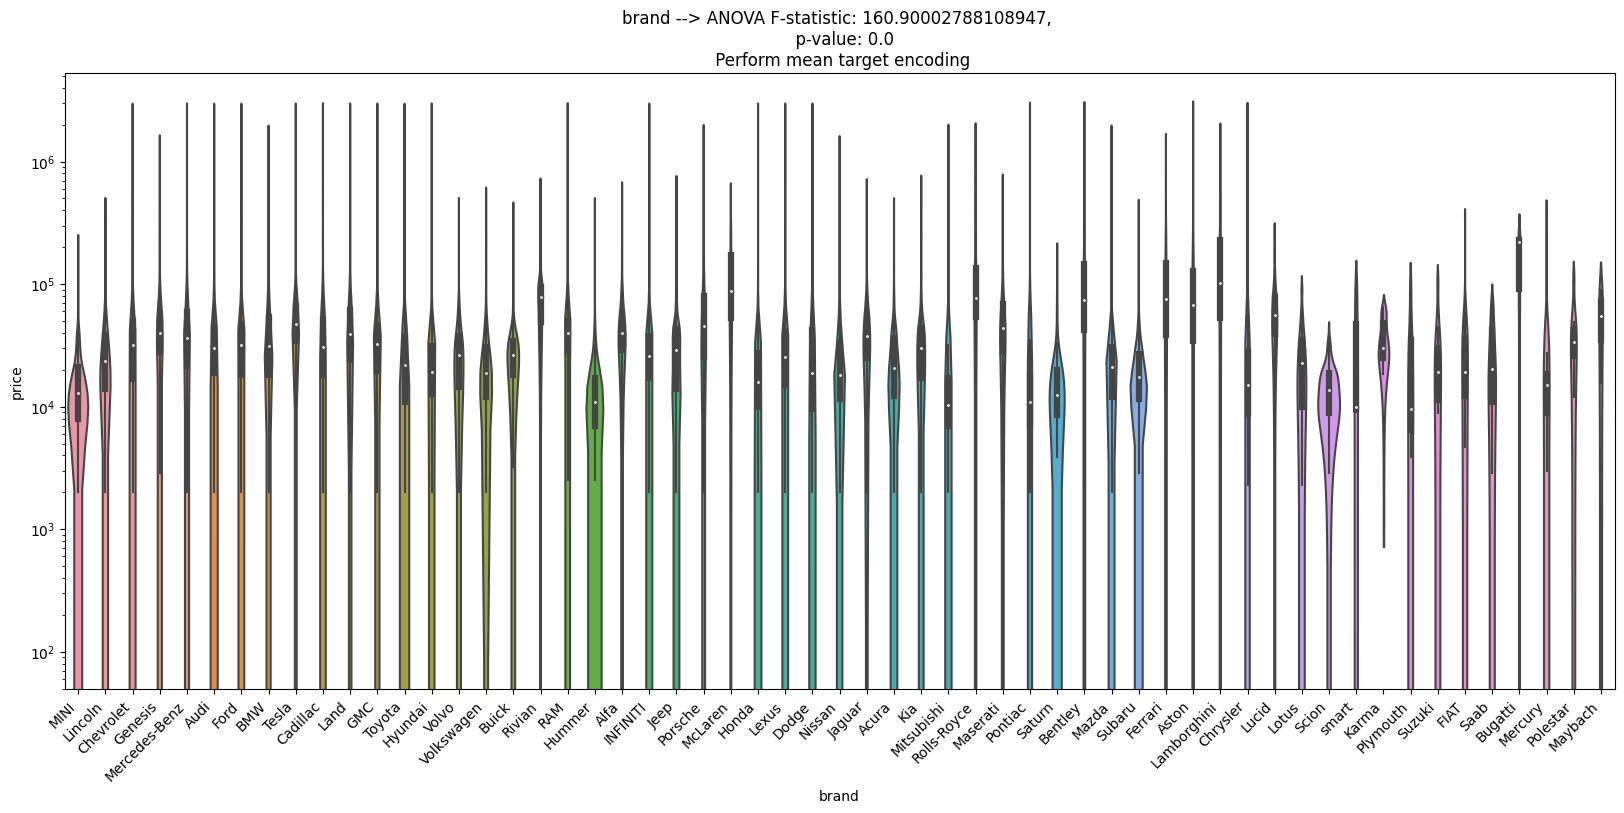

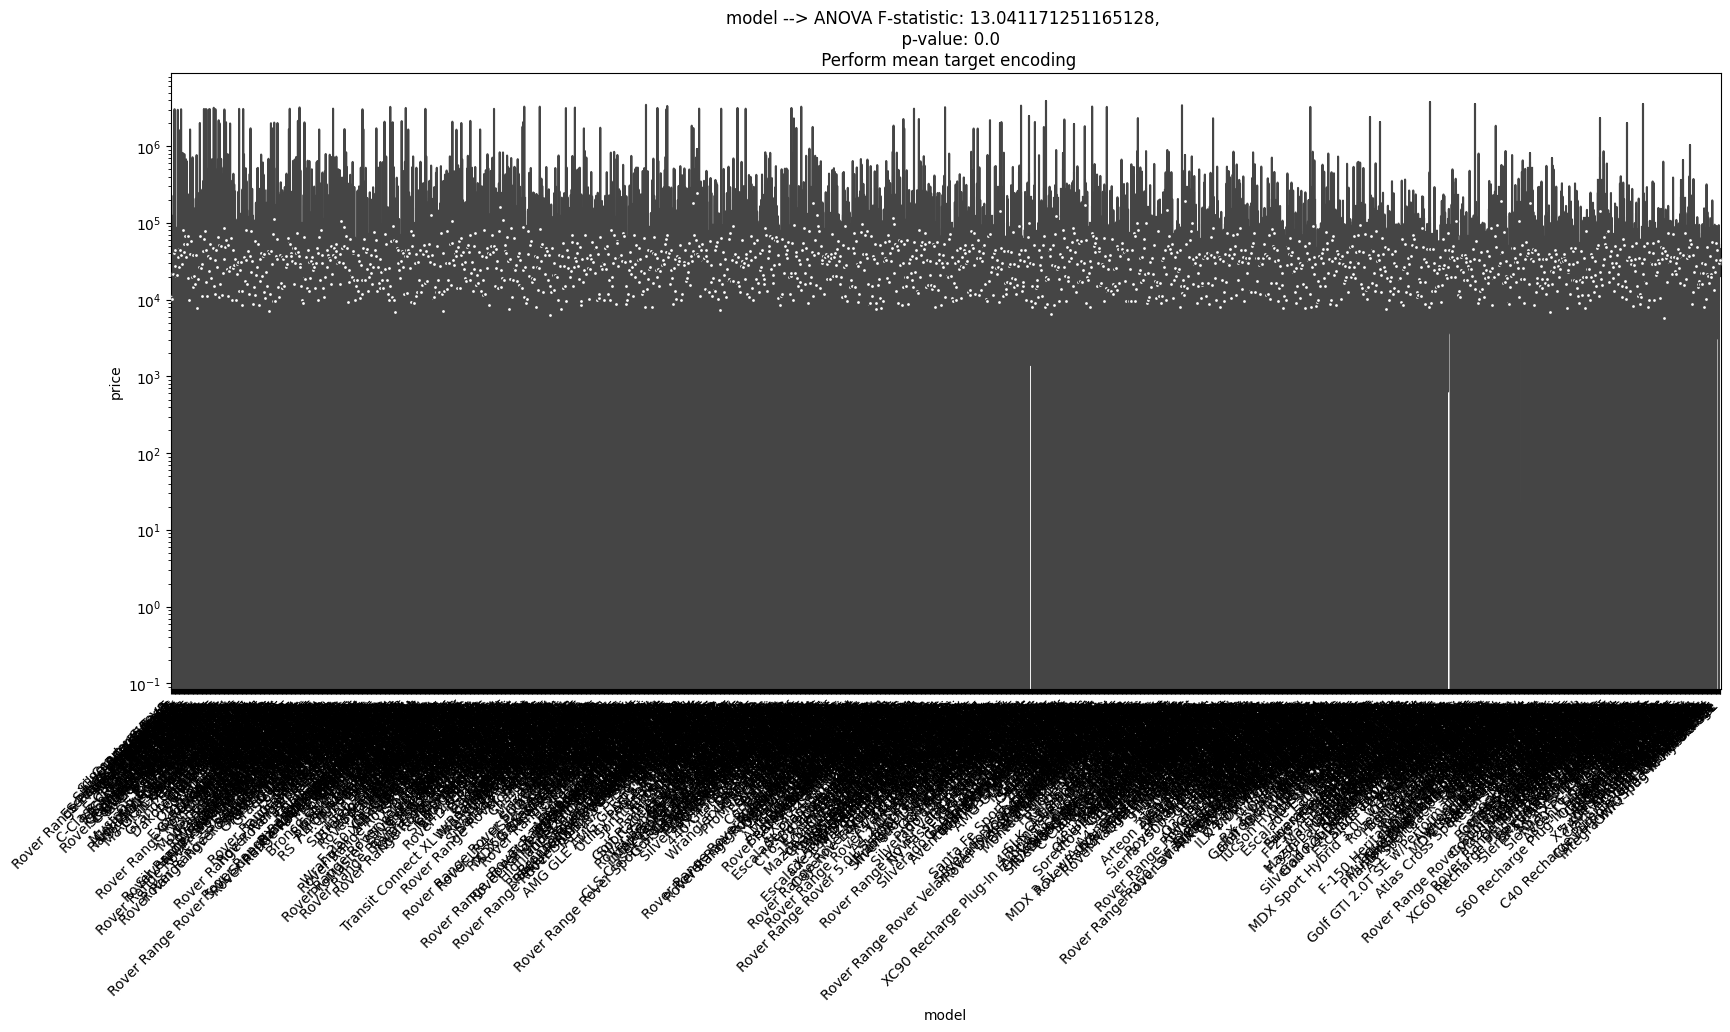

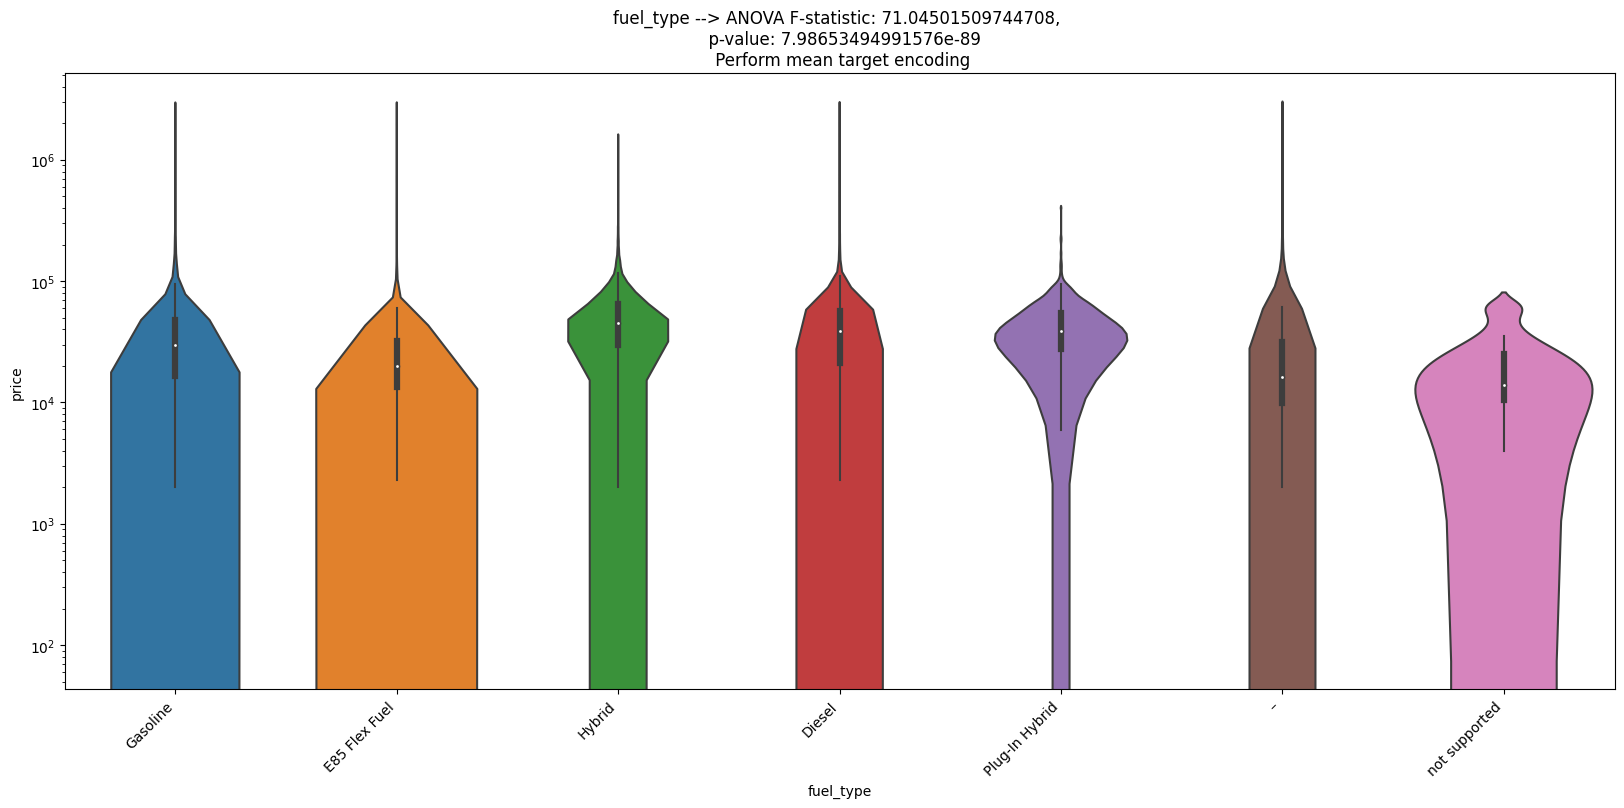

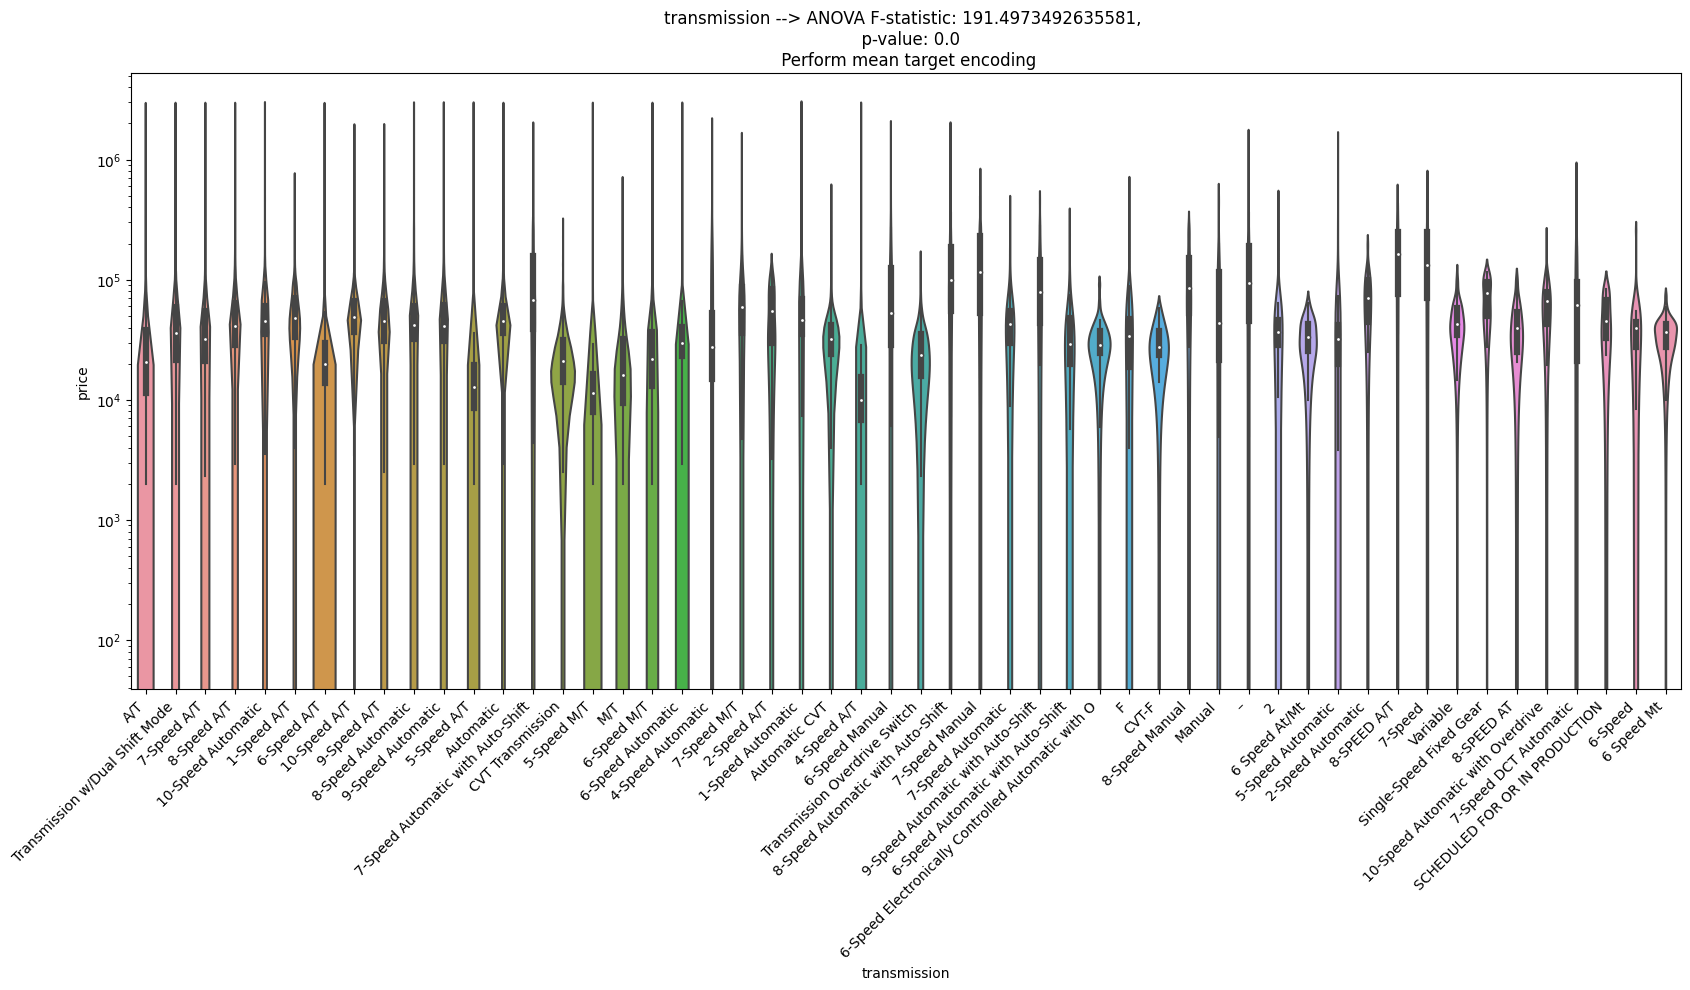

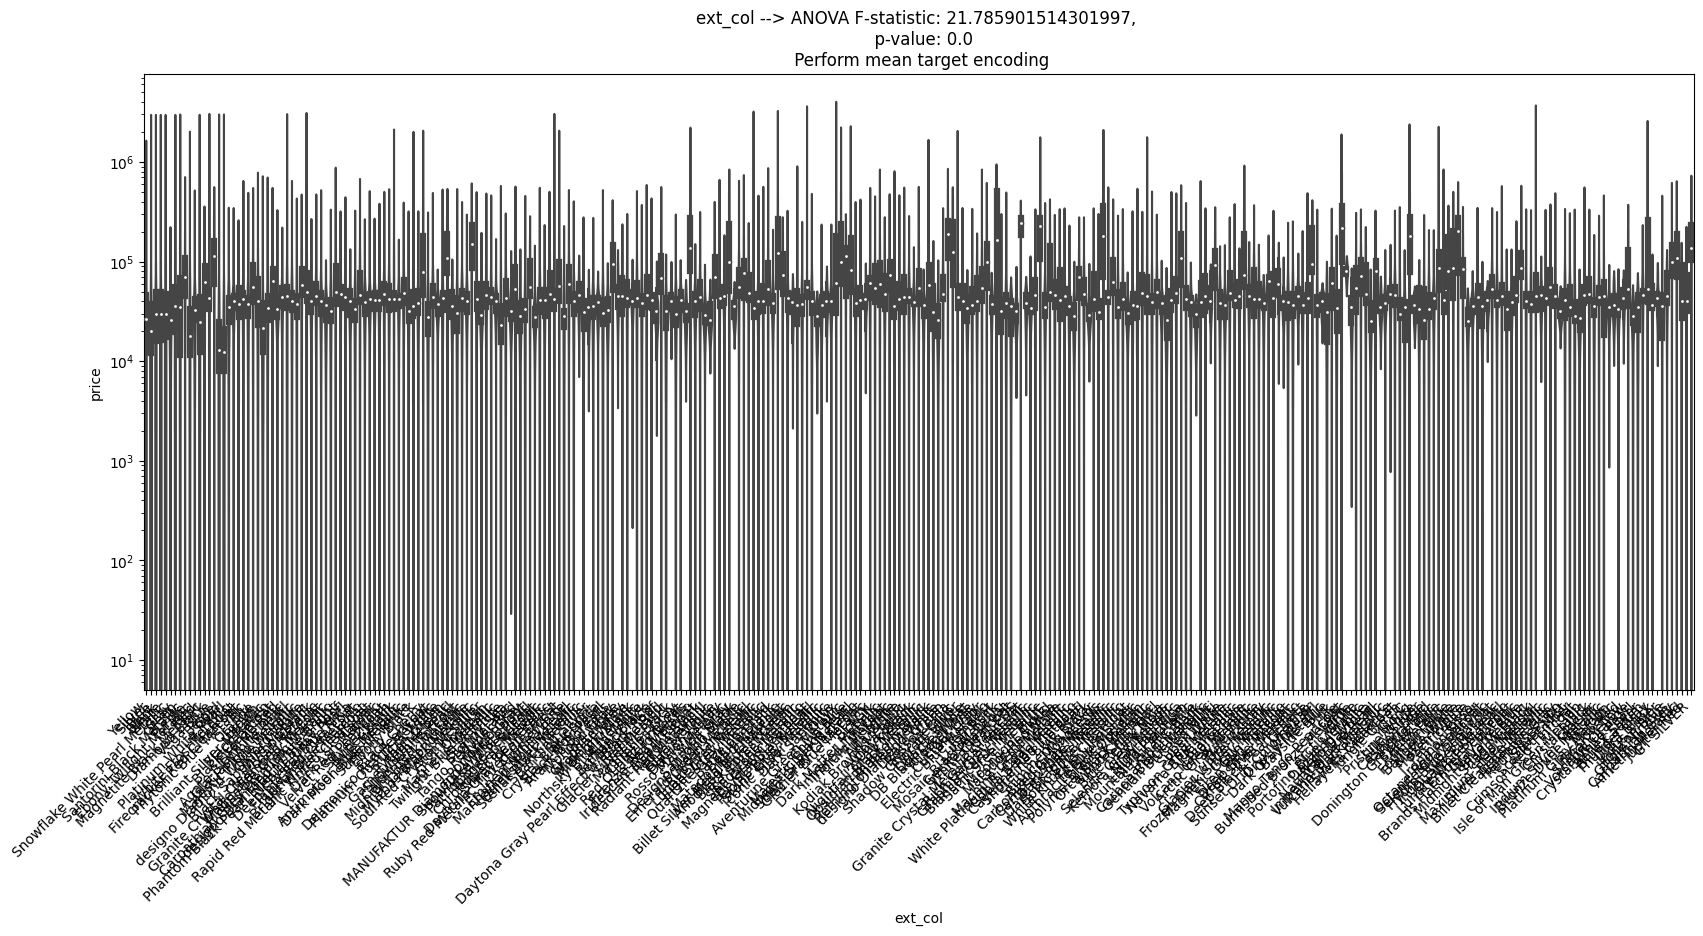

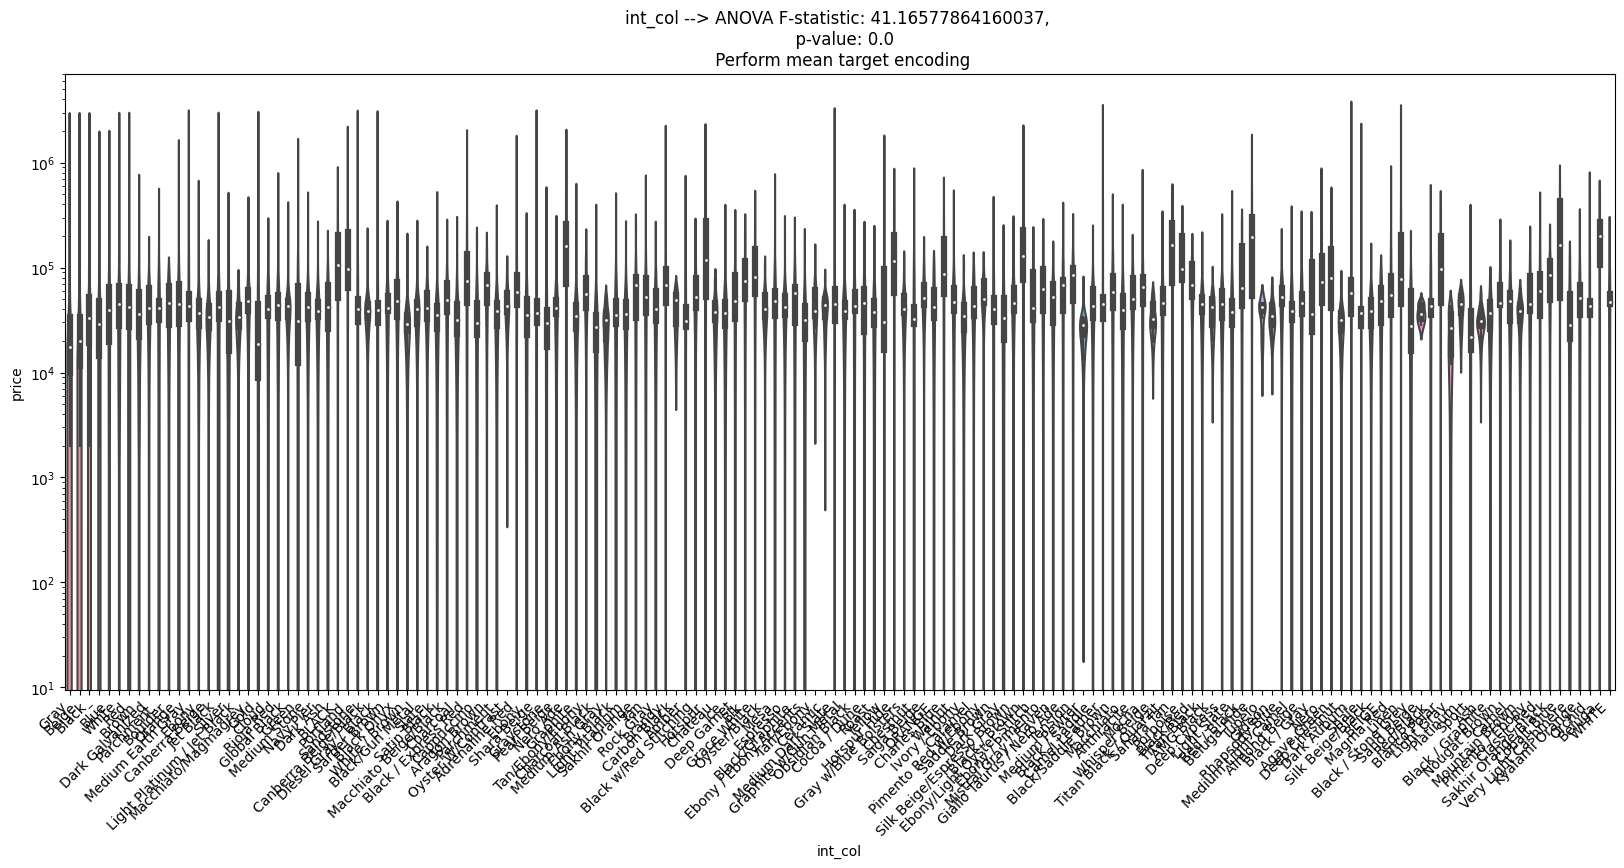

In [7]:
object_cols = train.select_dtypes(include = ['object']).columns

for col in object_cols:
    anovaVisualisation(train[[col, 'price']], [col, 'price'])
#     break
